In [107]:
import random

# path = "./dataset/valid"
path = "./dataset/train"

In [108]:
import json
 
f = open(path+"/_annotations.coco.json")
data = json.load(f)
 
id_to_image_name = {}
for image in data["images"]:
    id_to_image_name[image["id"]] = image["file_name"]

image_name_to_annotations = {}
for annotation in data["annotations"]:
    image_name_to_annotations[id_to_image_name[annotation["image_id"]]] = annotation
f.close()

In [109]:
def parse_to_images(image):
    w, h = 512, 512
    data = np.zeros((h, w, 3), dtype=np.uint8)
    data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
    return Image.fromarray(image, 'RGB')

In [110]:


def show_top(images, start=0, end=10, annotations = None):
    for name, image in list(images.items())[start:end]:
        fig, ax = plt.subplots()
        ax.imshow(image)
        plt.axis(False)
        print(name[:6])
        if annotations is not None and name in annotations.keys():
            bbox = annotations[name]["bbox"]
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        plt.show()
        
        
def show(image):
    fig, ax = plt.subplots()
    ax.imshow(image)
    plt.axis(False)
    plt.show()


In [111]:
import csv


def append_to_csv(name, csv_file = "labels.csv"):
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        # Append the new data to the CSV file
        writer.writerow([name + ";"])

In [112]:
from PIL import Image
import glob
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
 
# images_arr = []
# images_names = []
images_arr = {}
for f in glob.iglob(path+"/*.jpg"):
    images_arr[f[16:]] = np.asarray(Image.open(f))
    
    # images_arr.append(np.asarray(Image.open(f)))
    # images_names.append(f[16:])
# images_arr = np.array(images_arr)
# print(images_arr)
# print(images_arr["f1-184-_jpg.rf.751e0bd601848440ed76a3adf66661cb.jpg"])

images = {}
for name, image_arr in images_arr.items():
    images[name] = parse_to_images(image_arr)
    # append_to_csv(name)

start = 180
end = 0
show_top(images, start, end, image_name_to_annotations)

In [113]:
path = "./dataset/allll"

In [131]:
from PIL import Image
import glob
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
 
# images_arr = []
# images_names = []
images_arr = {}
for f in glob.iglob(path+"/*.jpg"):
    images_arr[f[16:]] = np.asarray(Image.open(f).resize((640, 640)))
    
    # images_arr.append(np.asarray(Image.open(f)))
    # images_names.append(f[16:])
# images_arr = np.array(images_arr)
# print(images_arr)
# print(images_arr["f1-184-_jpg.rf.751e0bd601848440ed76a3adf66661cb.jpg"].shape)
# print(images_arr["image3-29_png.rf.7e106e85552da8b8e95dcb545629fba6.jpg"].shape)

images = {}
for name, image_arr in images_arr.items():
    images[name] = parse_to_images(image_arr)
    # append_to_csv(name)

start = 0
end = 0
# show_top(images, start, end, image_name_to_annotations)

In [132]:
# !pip install -U scikit-learn scipy matplotlib

In [133]:
# for f in glob.iglob("./dataset/good/*.jpg"):
#     print(f[15:]+";4;3")

In [144]:
import pandas as pd

labels = pd.read_csv('some_labels.csv', sep=';') 

dataframe = pd.DataFrame({'image_name': labels["image_name"],
                          'image_arr': [images_arr[l] for l in labels["image_name"]],
                          'position_label': labels["position_label"],
                          'type_label': labels["type_label"],
                          'healthy_label': labels["healthy_label"]})
 
X = np.stack(dataframe["image_arr"].apply(lambda x: np.array(x)).values)
X_part = np.stack(dataframe[dataframe['healthy_label'] == 0]["image_arr"].apply(lambda x: np.array(x)).values)
healthy_labels = np.array(dataframe["healthy_label"])
position_labels = np.array(dataframe[dataframe['healthy_label'] == 0]["position_label"])
type_labels = np.array(dataframe[dataframe['healthy_label'] == 0]["type_label"])
# print(X)

In [149]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras import models


num_classes = 2
image_height = 640
image_width = 640
num_epochs = 10

# Split data into training and testing sets
X_train_position, X_test_position, y_train_position, y_test_position \
    = train_test_split(X, healthy_labels, test_size=0.2, random_state=42)

model_healthy = models.Sequential([
    # Convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    
    # Flatten layer
    layers.Flatten(),
    
    # Dense layers
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout for regularization
    layers.Dense(64, activation='relu'),
    
    # Output layer
    layers.Dense(num_classes, activation='softmax')  # num_classes is the number of output classes
])

# Compile the model
model_healthy.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_healthy.fit(X_train_position, y_train_position,
                             epochs=num_epochs, validation_data=(X_test_position, y_test_position))

# Evaluate the model
test_loss, test_acc = model_healthy.evaluate(X_test_position, y_test_position)
print('\nTest accuracy:', test_acc)
# Save the entire model to a file

C:\Studia\8. sem\Kogni\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.7564 - loss: 33.8213 - val_accuracy: 0.5983 - val_loss: 463.0885
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9185 - loss: 15.0154 - val_accuracy: 0.5983 - val_loss: 353.7086
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9350 - loss: 20.9208 - val_accuracy: 0.4957 - val_loss: 999.4251
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.9649 - loss: 4.9510 - val_accuracy: 0.6752 - val_loss: 569.1840
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9428 - loss: 11.7488 - val_accuracy: 0.9060 - val_loss: 27.6225
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.9566 - loss: 6.9388 - val_accuracy: 0.5385 - val_loss: 1052.5745
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9607 - loss: 4.9938 - val_accuracy: 0.7094 - val_loss: 430.4449
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.9599 - loss: 8.0899 - val_accuracy: 

In [150]:
num_classes = 4

# Split data into training and testing sets
X_train_position, X_test_position, y_train_position, y_test_position \
    = train_test_split(X_part, position_labels, test_size=0.2, random_state=42)

model_position = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Flatten layer
    Flatten(),
    
    # Dense layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')  # num_classes is the number of output classes
])

# Compile the model
model_position.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_position.fit(X_train_position, y_train_position,
                             epochs=num_epochs, validation_data=(X_test_position, y_test_position))

# Evaluate the model
test_loss, test_acc = model_position.evaluate(X_test_position, y_test_position)
print('\nTest accuracy:', test_acc)
# Save the entire model to a file

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 5s/step - accuracy: 0.3120 - loss: 41.0295 - val_accuracy: 0.3455 - val_loss: 715.8165
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - accuracy: 0.4686 - loss: 37.2092 - val_accuracy: 0.3455 - val_loss: 1304.9324
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.5563 - loss: 44.8161 - val_accuracy: 0.3455 - val_loss: 1659.1017
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5649 - loss: 36.5529 - val_accuracy: 0.3455 - val_loss: 1889.9705
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.6265 - loss: 42.0827 - val_accuracy: 0.3636 - val_loss: 1678.7710
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.6960 - loss: 23.7294 - val_accuracy: 0.4182 - val_loss: 710.3684
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.7062 - loss: 16.9863 - val_accuracy: 0.4727 - val_loss: 302.7549
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.6659 - loss: 26.5600 - val_accuracy: 0.4909 -

In [151]:
num_classes = 3
# Split data into training and testing sets
X_train_type, X_test_type, y_train_type, y_test_type \
    = train_test_split(X_part, type_labels, test_size=0.2, random_state=42)

# Define CNN model
model_type = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    
    # Flatten layer
    Flatten(),
    
    # Dense layers
    Dense(512, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(256, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(num_classes, activation='softmax')  # num_classes is the number of output classes
])

# Compile the model
model_type.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model_type.fit(X_train_type, y_train_type,
                         epochs=num_epochs, validation_data=(X_test_type, y_test_type))

# Evaluate the model
test_loss, test_acc = model_type.evaluate(X_test_type, y_test_type)
print('\nTest accuracy:', test_acc)
# Save the entire model to a file


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.4457 - loss: 40.6399 - val_accuracy: 0.7636 - val_loss: 213.8915
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.5683 - loss: 41.2334 - val_accuracy: 0.7636 - val_loss: 601.2596
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.6776 - loss: 32.2068 - val_accuracy: 0.7636 - val_loss: 1483.3696
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.6609 - loss: 30.1301 - val_accuracy: 0.7636 - val_loss: 1316.5012
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.6620 - loss: 33.8419 - val_accuracy: 0.7636 - val_loss: 1010.9854
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.7604 - loss: 14.8826 - val_accuracy: 0.7636 - val_loss: 577.0956
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - accuracy: 0.6580 - loss: 22.8553 - val_accuracy: 0.7636 - val_loss: 378.8871
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - accuracy: 0.7339 - loss: 24.1462 - val_accuracy: 0.7636 - 

In [158]:
# Save only the weights of the model
model_healthy.save_weights("models/healthy_model_weights.weights.h5")


In [155]:
model_healthy.save("models/healthy_model.h5")
model_type.save("models/type_model.h5")
model_position.save("models/position_model.h5")

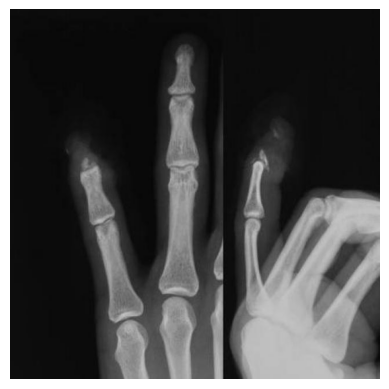

[[[[ 12  12  12]
   [ 12  12  12]
   [ 12  12  12]
   ...
   [ 11  11  11]
   [ 11  11  11]
   [ 11  11  11]]

  [[ 12  12  12]
   [ 12  12  12]
   [ 12  12  12]
   ...
   [ 11  11  11]
   [ 11  11  11]
   [ 11  11  11]]

  [[ 12  12  12]
   [ 12  12  12]
   [ 12  12  12]
   ...
   [ 11  11  11]
   [ 11  11  11]
   [ 11  11  11]]

  ...

  [[ 14  14  14]
   [ 14  14  14]
   [ 14  14  14]
   ...
   [ 93  93  93]
   [ 94  94  94]
   [ 97  97  97]]

  [[ 14  14  14]
   [ 14  14  14]
   [ 14  14  14]
   ...
   [ 94  94  94]
   [ 96  96  96]
   [ 99  99  99]]

  [[ 14  14  14]
   [ 14  14  14]
   [ 14  14  14]
   ...
   [ 95  95  95]
   [ 97  97  97]
   [100 100 100]]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted: Uszkodzona dłoń.  Złamanie palca 
Expected: Uszkodzona dłoń.  Złamanie palca


In [156]:
import random

label_healthy_dict = {0:"Uszkodzona dłoń. ",1: "Zdrowa dłoń."}
label_position_dict = {0:"palca",1: "dłoni",2: "nadgarstka",3: "wielokrotne"}
label_type_dict = {0:"Złamanie",1: "Przesunięcie",2: "Stłuczenie"}

# id = 1
for i in range(1):
    id = random.randint(0, len(X_test_position))
    example_input = X_test_position[id]
    show(example_input)
    example_input = np.expand_dims(example_input, axis=0)
    
    print(example_input)
    predictions_healthy = model_healthy.predict(example_input)
    predicted_label_healthy = np.argmax(predictions_healthy)
    
    predictions_position = model_position.predict(example_input)
    predicted_label_position = np.argmax(predictions_position)
    
    predictions_type = model_type.predict(example_input)
    predicted_label_type= np.argmax(predictions_type)
    
    print("Predicted:", label_healthy_dict[predicted_label_healthy], label_type_dict[predicted_label_type], label_position_dict[predicted_label_position], 
          "\nExpected:", label_healthy_dict[predicted_label_healthy], label_type_dict[y_test_type[id]], label_position_dict[y_test_position[id]])